In [1]:
import os

In [2]:
if not os.path.exists("data"):
  !wget -q https://www.dropbox.com/s/4f314zcoo0lvlzn/Brain%20Tumor%20Segmentation.zip?dl=0 --output-document tumor_dataset.zip
  !unzip -q tumor_dataset.zip
  !rm tumor_dataset.zip
  !pip install -q torch_snippets pytorch_model_summary
  !pip install -U segmentation-models-pytorch albumentations --user 
  
  !pip install tensorflow==2.1.0
  !pip install keras==2.3.1

In [12]:
  !pip install segmentation_models_pytorch==0.2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:

from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [2]:
import albumentations as albu

In [3]:
from torchsummary import summary

In [4]:
import numpy as np
from skimage import color


In [5]:
import segmentation_models_pytorch as smp

In [6]:
data_dir = "data"
image_dir_name = "images"
mask_dir_name = "masks"
image_dir = os.path.join(data_dir,image_dir_name)
mask_dir = os.path.join(data_dir,mask_dir_name)

In [7]:
images = Glob(os.path.join(image_dir,"*.png"))
masks = Glob(os.path.join(mask_dir, "*.png"))

In [8]:
print(len(images), len(masks))

3064 3064

# Visualizations

In [9]:
img = read(images[0],1)

In [10]:
img.shape

(512, 512, 3)

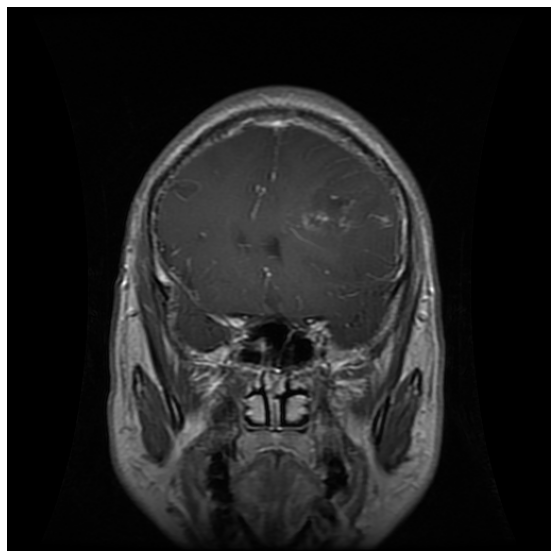

In [11]:
show(img)

In [12]:
msk = read(masks[0])


(512, 512)

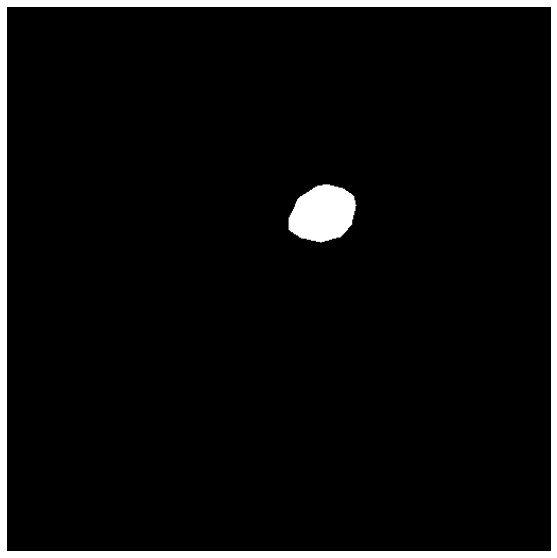

In [13]:
print(msk.shape)
show(msk)

In [14]:
msk = np.stack((msk,msk,msk),axis = 2)

In [15]:
overlayed_img = np.where(msk, (255,0,0), img) # Red overlay (255,0,0)

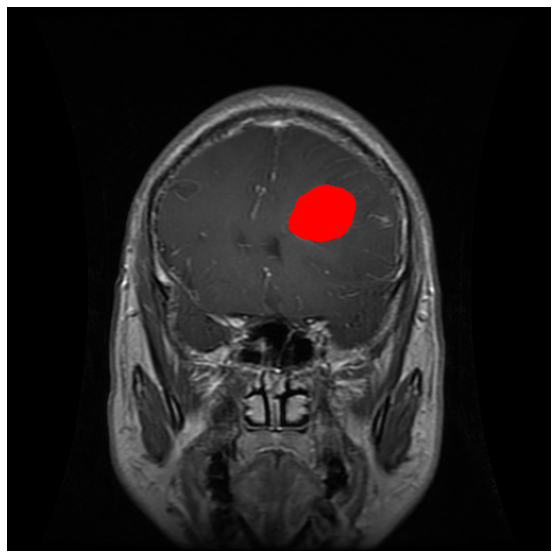

In [16]:
show(overlayed_img)

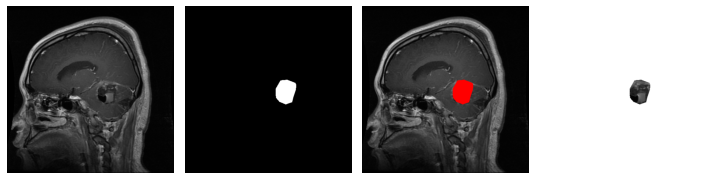

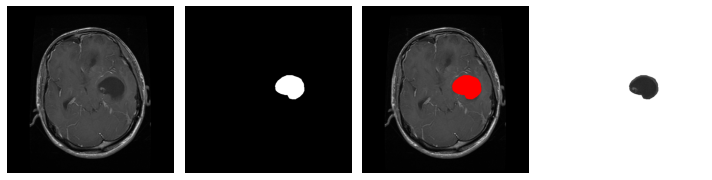

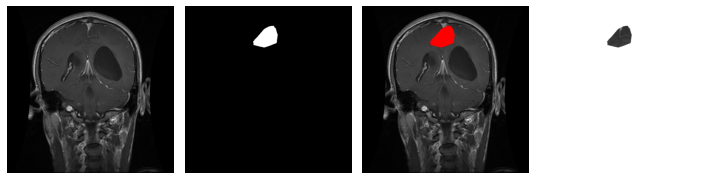

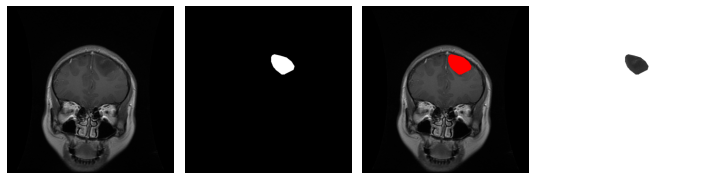

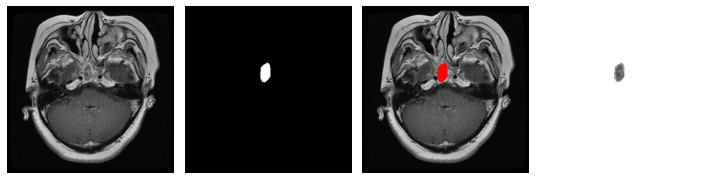

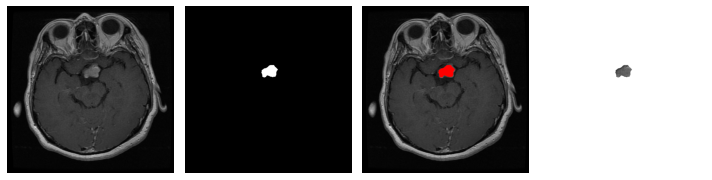

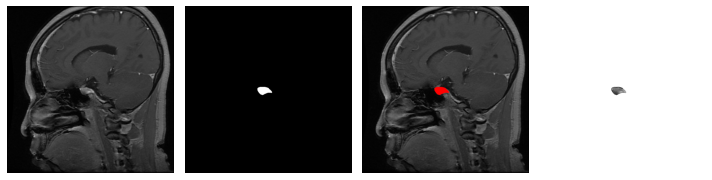

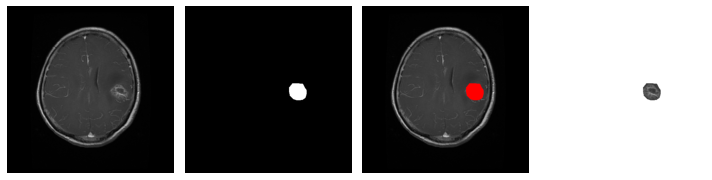

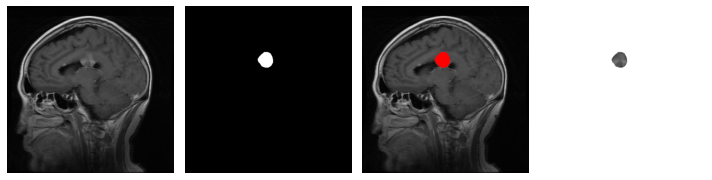

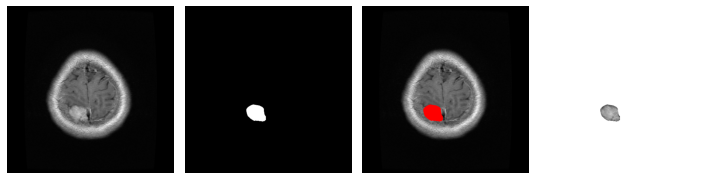

In [17]:

for i in range(10):
  index = np.random.choice(len(images))
  img = read(images[index],1)
  msk = read(masks[index])
  msk_stack = np.stack((msk,msk,msk),axis = 2)
  overlayed_img = np.where(msk_stack, (255,0,0), img) # Red overlay (255,0,0)

  rgba = cv2.cvtColor(img, cv2.COLOR_RGB2RGBA)
  rgba[:, :, 3] = msk
  subplots([img,msk, overlayed_img, rgba], figsize = (10,10))


# Training and Validation Split

In [18]:
combined = list(zip(images,masks))

In [19]:
trn_files, val_files = train_test_split(combined, random_state = 42,test_size=0.2)

# DataSet class

In [20]:
os.cpu_count()

2

In [21]:
# Image Transformation object
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [22]:
mask_tfms = transforms.ToTensor()

In [23]:
class BrainTumorDataset(Dataset):
  def __init__(self, items, augmentation = None,preprocessing = None):
    self.items = items
    self.preprocessing = preprocessing
    self.augmentation = augmentation

  def __len__(self):
    return len(self.items)

  def __getitem__(self, ix):
    item = self.items[ix]
    
    ## Getting image and mask path
    image_path = item[0]
    mask_path = item[1]
    
    ### Ingesting image and mask 
    image = read(image_path,1)
    mask = read(mask_path)

    ### resizing image and mask to 224,224. Will start with vgg16 backbone
    image = cv2.resize(image, (224,224))
    mask = cv2.resize(mask, (224,224))
    image = image/255.
    mask = mask/255.
    
    ## Adding depth dimension as image is greyscale
    mask = mask[...,np.newaxis]

    if self.augmentation:
      sample = self.augmentation(image = image, mask = mask)
      image,mask = sample['image'], sample['mask']
    
    # apply preprocessing
    if self.preprocessing:
      sample = self.preprocessing(image = image, mask = mask)
      image, mask = sample['image'], sample['mask']


    return image, mask

  # def collate_fn(self,batch):
  #   ims, masks = list(zip(*batch))
  #   #print(ims)
  #   ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)

  #   ###########  Changing mask to float
  #   #ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).float().to(device)
  #   ce_masks = torch.cat([mask_tfms(mask.copy()/255.)[None] for mask in masks]).float().to(device)
    
  #   return ims, ce_masks

  def choose(self):
    return self[randint(len(self))]







In [24]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

## Augmentation functions

In [25]:
import albumentations as albu

In [26]:
def get_training_augmentation():
  train_transform = [
      albu.HorizontalFlip(), 
      albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

      # albu.OneOf(
      #       [
      #           # albu.CLAHE(p=1),
      #           albu.RandomBrightness(p=1),
      #           albu.RandomGamma(p=1),
      #       ],
      #       p=0.9,
      #   ),

      #   albu.OneOf(
      #       [
      #           albu.IAASharpen(p=1),
      #           albu.Blur(blur_limit=3, p=1),
      #           albu.MotionBlur(blur_limit=3, p=1),
      #       ],
      #       p=0.9,
      #   ),

      #   albu.OneOf(
      #       [
      #           albu.RandomContrast(p=1),
      #           albu.HueSaturationValue(p=1),
      #       ],
      #       p=0.9,
      #   ),        
        
      ]


  return albu.Compose(train_transform)


In [27]:
def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [28]:
ENCODER = 'vgg16_bn'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'
DEVICE = device
CLASSES = ['tumor']
preprocessing_fn  = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [29]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [30]:
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

In [31]:
train_ds = BrainTumorDataset(items=trn_files, preprocessing = get_preprocessing(preprocessing_fn), augmentation=get_training_augmentation())


In [32]:
temp_img, temp_msk = train_ds[0]

In [33]:
temp_img.shape

(3, 224, 224)

In [34]:
temp_msk.shape

(1, 224, 224)

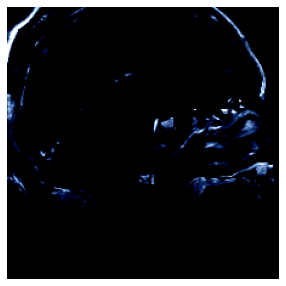

In [35]:
show(temp_img)

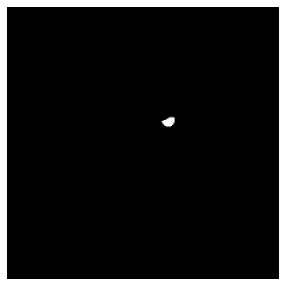

In [36]:
show(temp_msk.reshape((224,224)))

In [37]:
valid_ds  =  BrainTumorDataset(items=val_files, preprocessing = get_preprocessing(preprocessing_fn))


In [38]:
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_ds, batch_size=1, shuffle=False, num_workers=4)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [39]:
loss = smp.losses.DiceLoss(mode = 'binary')

In [40]:
def IOU_Score(output,target,mode = 'binary',threshold = 0.5):
  tp, fp, fn, tn = smp.metrics.get_stats(output, target, mode=mode, threshold=threshold)
  iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
  return iou_score

In [41]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])


In [42]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [43]:
# train model

n_epochs = 40

max_score = 0

log = Report(n_epochs)
for i in range(0, n_epochs):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    log.record( pos=(i+1),trn_dice_loss=train_logs['dice_loss'], trn_iou_score=train_logs['iou_score'], valid_dice_log = valid_logs['dice_loss'], valid_iou_score=valid_logs['iou_score'],end='\r')
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

Epoch: 0

valid: 100%|██████████| 613/613 [00:12<00:00, 48.43it/s, dice_loss - 0.6426, iou_score - 0.4707]
EPOCH: 1.000  trn_dice_loss: 0.784  trn_iou_score: 0.270  valid_dice_log: 0.643  valid_iou_score: 0.471  (93.19s - 3634.60s remaining)

Model saved!

Epoch: 1

valid: 100%|██████████| 613/613 [00:12<00:00, 49.08it/s, dice_loss - 0.3798, iou_score - 0.5984]
EPOCH: 2.000  trn_dice_loss: 0.401  trn_iou_score: 0.549  valid_dice_log: 0.380  valid_iou_score: 0.598  (178.21s - 3385.92s remaining)

Model saved!

Epoch: 2

valid: 100%|██████████| 613/613 [00:13<00:00, 44.41it/s, dice_loss - 0.2947, iou_score - 0.6419]
EPOCH: 3.000  trn_dice_loss: 0.284  trn_iou_score: 0.607  valid_dice_log: 0.295  valid_iou_score: 0.642  (264.81s - 3265.94s remaining)

Model saved!

Epoch: 3

valid: 100%|██████████| 613/613 [00:12<00:00, 47.73it/s, dice_loss - 0.3025, iou_score - 0.6289]
EPOCH: 4.000  trn_dice_loss: 0.244  trn_iou_score: 0.638  valid_dice_log: 0.303  valid_iou_score: 0.629  (351.69s - 3165.17s remaining)

Epoch: 4

valid: 100%|██████████| 613/613 [00:11<00:00, 54.11it/s, dice_loss - 0.2649, iou_score - 0.6554]
EPOCH: 5.000  trn_dice_loss: 0.225  trn_iou_score: 0.655  valid_dice_log: 0.265  valid_iou_score: 0.655  (436.37s - 3054.61s remaining)

Model saved!

Epoch: 5

valid: 100%|██████████| 613/613 [00:14<00:00, 42.95it/s, dice_loss - 0.2637, iou_score - 0.657]
EPOCH: 6.000  trn_dice_loss: 0.210  trn_iou_score: 0.671  valid_dice_log: 0.264  valid_iou_score: 0.657  (524.85s - 2974.15s remaining)

Model saved!

Epoch: 6

valid: 100%|██████████| 613/613 [00:12<00:00, 50.11it/s, dice_loss - 0.2983, iou_score - 0.6204]
EPOCH: 7.000  trn_dice_loss: 0.197  trn_iou_score: 0.687  valid_dice_log: 0.298  valid_iou_score: 0.620  (609.77s - 2874.62s remaining)

Epoch: 7

valid: 100%|██████████| 613/613 [00:12<00:00, 48.40it/s, dice_loss - 0.236, iou_score - 0.6759]
EPOCH: 8.000  trn_dice_loss: 0.187  trn_iou_score: 0.698  valid_dice_log: 0.236  valid_iou_score: 0.676  (695.23s - 2780.93s remaining)

Model saved!

Epoch: 8

valid: 100%|██████████| 613/613 [00:14<00:00, 42.73it/s, dice_loss - 0.2331, iou_score - 0.6786]
EPOCH: 9.000  trn_dice_loss: 0.187  trn_iou_score: 0.698  valid_dice_log: 0.233  valid_iou_score: 0.679  (782.25s - 2694.41s remaining)

Model saved!

Epoch: 9

valid: 100%|██████████| 613/613 [00:11<00:00, 51.79it/s, dice_loss - 0.2064, iou_score - 0.7067]
EPOCH: 10.000  trn_dice_loss: 0.186  trn_iou_score: 0.697  valid_dice_log: 0.206  valid_iou_score: 0.707  (867.45s - 2602.35s remaining)

Model saved!

Epoch: 10

valid: 100%|██████████| 613/613 [00:12<00:00, 48.44it/s, dice_loss - 0.2568, iou_score - 0.6534]
EPOCH: 11.000  trn_dice_loss: 0.188  trn_iou_score: 0.694  valid_dice_log: 0.257  valid_iou_score: 0.653  (954.31s - 2515.90s remaining)

Epoch: 11

valid: 100%|██████████| 613/613 [00:14<00:00, 43.61it/s, dice_loss - 0.242, iou_score - 0.6702]
EPOCH: 12.000  trn_dice_loss: 0.186  trn_iou_score: 0.698  valid_dice_log: 0.242  valid_iou_score: 0.670  (1041.15s - 2429.34s remaining)

Epoch: 12

valid: 100%|██████████| 613/613 [00:12<00:00, 48.49it/s, dice_loss - 0.2529, iou_score - 0.6651]
EPOCH: 13.000  trn_dice_loss: 0.182  trn_iou_score: 0.703  valid_dice_log: 0.253  valid_iou_score: 0.665  (1126.99s - 2340.68s remaining)

Epoch: 13

valid: 100%|██████████| 613/613 [00:12<00:00, 50.08it/s, dice_loss - 0.2054, iou_score - 0.7053]
EPOCH: 14.000  trn_dice_loss: 0.169  trn_iou_score: 0.720  valid_dice_log: 0.205  valid_iou_score: 0.705  (1211.80s - 2250.49s remaining)

Epoch: 14

valid: 100%|██████████| 613/613 [00:14<00:00, 43.47it/s, dice_loss - 0.2658, iou_score - 0.6529]
EPOCH: 15.000  trn_dice_loss: 0.165  trn_iou_score: 0.725  valid_dice_log: 0.266  valid_iou_score: 0.653  (1298.65s - 2164.41s remaining)

Epoch: 15

valid: 100%|██████████| 613/613 [00:12<00:00, 48.16it/s, dice_loss - 0.2244, iou_score - 0.6897]
EPOCH: 16.000  trn_dice_loss: 0.166  trn_iou_score: 0.724  valid_dice_log: 0.224  valid_iou_score: 0.690  (1383.72s - 2075.58s remaining)

Epoch: 16

valid: 100%|██████████| 613/613 [00:12<00:00, 47.92it/s, dice_loss - 0.2136, iou_score - 0.702]
EPOCH: 17.000  trn_dice_loss: 0.162  trn_iou_score: 0.729  valid_dice_log: 0.214  valid_iou_score: 0.702  (1469.36s - 1987.96s remaining)

Epoch: 17

valid: 100%|██████████| 613/613 [00:14<00:00, 43.03it/s, dice_loss - 0.2153, iou_score - 0.6967]
EPOCH: 18.000  trn_dice_loss: 0.155  trn_iou_score: 0.739  valid_dice_log: 0.215  valid_iou_score: 0.697  (1556.12s - 1901.93s remaining)

Epoch: 18

valid: 100%|██████████| 613/613 [00:11<00:00, 51.89it/s, dice_loss - 0.2029, iou_score - 0.7131]
EPOCH: 19.000  trn_dice_loss: 0.153  trn_iou_score: 0.742  valid_dice_log: 0.203  valid_iou_score: 0.713  (1640.46s - 1813.13s remaining)

Model saved!

Epoch: 19

valid: 100%|██████████| 613/613 [00:12<00:00, 49.12it/s, dice_loss - 0.2478, iou_score - 0.6627]
EPOCH: 20.000  trn_dice_loss: 0.174  trn_iou_score: 0.713  valid_dice_log: 0.248  valid_iou_score: 0.663  (1727.63s - 1727.63s remaining)

Epoch: 20

valid: 100%|██████████| 613/613 [00:13<00:00, 45.06it/s, dice_loss - 0.2146, iou_score - 0.6989]
EPOCH: 21.000  trn_dice_loss: 0.164  trn_iou_score: 0.726  valid_dice_log: 0.215  valid_iou_score: 0.699  (1814.05s - 1641.28s remaining)

Epoch: 21

valid: 100%|██████████| 613/613 [00:11<00:00, 53.98it/s, dice_loss - 0.193, iou_score - 0.7209]
EPOCH: 22.000  trn_dice_loss: 0.152  trn_iou_score: 0.742  valid_dice_log: 0.193  valid_iou_score: 0.721  (1899.14s - 1553.84s remaining)

Model saved!

Epoch: 22

valid: 100%|██████████| 613/613 [00:13<00:00, 44.55it/s, dice_loss - 0.2039, iou_score - 0.7086]
EPOCH: 23.000  trn_dice_loss: 0.147  trn_iou_score: 0.749  valid_dice_log: 0.204  valid_iou_score: 0.709  (1986.99s - 1468.64s remaining)

Epoch: 23

valid: 100%|██████████| 613/613 [00:12<00:00, 47.76it/s, dice_loss - 0.2074, iou_score - 0.705]
EPOCH: 24.000  trn_dice_loss: 0.146  trn_iou_score: 0.752  valid_dice_log: 0.207  valid_iou_score: 0.705  (2072.76s - 1381.84s remaining)

Epoch: 24

valid: 100%|██████████| 613/613 [00:11<00:00, 51.37it/s, dice_loss - 0.2066, iou_score - 0.7067]
EPOCH: 25.000  trn_dice_loss: 0.143  trn_iou_score: 0.756  valid_dice_log: 0.207  valid_iou_score: 0.707  (2157.52s - 1294.51s remaining)

Epoch: 25

valid: 100%|██████████| 613/613 [00:14<00:00, 42.36it/s, dice_loss - 0.1944, iou_score - 0.723]
EPOCH: 26.000  trn_dice_loss: 0.143  trn_iou_score: 0.756  valid_dice_log: 0.194  valid_iou_score: 0.723  (2245.92s - 1209.34s remaining)

Model saved!

Decrease decoder learning rate to 1e-5!

Epoch: 26

valid: 100%|██████████| 613/613 [00:12<00:00, 47.21it/s, dice_loss - 0.1913, iou_score - 0.7251]
EPOCH: 27.000  trn_dice_loss: 0.127  trn_iou_score: 0.779  valid_dice_log: 0.191  valid_iou_score: 0.725  (2332.18s - 1122.90s remaining)

Model saved!

Epoch: 27

valid: 100%|██████████| 613/613 [00:12<00:00, 51.02it/s, dice_loss - 0.1839, iou_score - 0.7324]
EPOCH: 28.000  trn_dice_loss: 0.124  trn_iou_score: 0.784  valid_dice_log: 0.184  valid_iou_score: 0.732  (2417.49s - 1036.07s remaining)

Model saved!

Epoch: 28

valid: 100%|██████████| 613/613 [00:13<00:00, 47.10it/s, dice_loss - 0.1876, iou_score - 0.7294]
EPOCH: 29.000  trn_dice_loss: 0.120  trn_iou_score: 0.789  valid_dice_log: 0.188  valid_iou_score: 0.729  (2506.21s - 950.63s remaining)

Epoch: 29

valid: 100%|██████████| 613/613 [00:13<00:00, 46.99it/s, dice_loss - 0.1805, iou_score - 0.736]
EPOCH: 30.000  trn_dice_loss: 0.119  trn_iou_score: 0.792  valid_dice_log: 0.181  valid_iou_score: 0.736  (2593.48s - 864.49s remaining)

Model saved!

Epoch: 30

valid: 100%|██████████| 613/613 [00:14<00:00, 42.57it/s, dice_loss - 0.1781, iou_score - 0.7383]
EPOCH: 31.000  trn_dice_loss: 0.117  trn_iou_score: 0.794  valid_dice_log: 0.178  valid_iou_score: 0.738  (2681.17s - 778.40s remaining)

Model saved!

Epoch: 31

valid: 100%|██████████| 613/613 [00:12<00:00, 47.19it/s, dice_loss - 0.1825, iou_score - 0.7341]
EPOCH: 32.000  trn_dice_loss: 0.114  trn_iou_score: 0.799  valid_dice_log: 0.183  valid_iou_score: 0.734  (2768.40s - 692.10s remaining)

Epoch: 32

valid: 100%|██████████| 613/613 [00:11<00:00, 51.54it/s, dice_loss - 0.1826, iou_score - 0.7336]
EPOCH: 33.000  trn_dice_loss: 0.114  trn_iou_score: 0.800  valid_dice_log: 0.183  valid_iou_score: 0.734  (2853.15s - 605.21s remaining)

Epoch: 33

valid: 100%|██████████| 613/613 [00:12<00:00, 47.51it/s, dice_loss - 0.1792, iou_score - 0.7358]
EPOCH: 34.000  trn_dice_loss: 0.114  trn_iou_score: 0.798  valid_dice_log: 0.179  valid_iou_score: 0.736  (2939.72s - 518.77s remaining)

Epoch: 34

valid: 100%|██████████| 613/613 [00:12<00:00, 48.63it/s, dice_loss - 0.1804, iou_score - 0.7342]
EPOCH: 35.000  trn_dice_loss: 0.112  trn_iou_score: 0.803  valid_dice_log: 0.180  valid_iou_score: 0.734  (3025.28s - 432.18s remaining)

Epoch: 35

valid: 100%|██████████| 613/613 [00:14<00:00, 41.86it/s, dice_loss - 0.1769, iou_score - 0.7389]
EPOCH: 36.000  trn_dice_loss: 0.110  trn_iou_score: 0.805  valid_dice_log: 0.177  valid_iou_score: 0.739  (3112.91s - 345.88s remaining)

Model saved!

Epoch: 36

valid: 100%|██████████| 613/613 [00:13<00:00, 47.15it/s, dice_loss - 0.1753, iou_score - 0.7399]
EPOCH: 37.000  trn_dice_loss: 0.110  trn_iou_score: 0.806  valid_dice_log: 0.175  valid_iou_score: 0.740  (3199.05s - 259.38s remaining)

Model saved!

Epoch: 37

valid: 100%|██████████| 613/613 [00:13<00:00, 46.74it/s, dice_loss - 0.1791, iou_score - 0.7366]
EPOCH: 38.000  trn_dice_loss: 0.107  trn_iou_score: 0.809  valid_dice_log: 0.179  valid_iou_score: 0.737  (3285.51s - 172.92s remaining)

Epoch: 38

valid: 100%|██████████| 613/613 [00:12<00:00, 47.61it/s, dice_loss - 0.175, iou_score - 0.741]
EPOCH: 39.000  trn_dice_loss: 0.108  trn_iou_score: 0.809  valid_dice_log: 0.175  valid_iou_score: 0.741  (3371.81s - 86.46s remaining)

Model saved!

Epoch: 39

valid: 100%|██████████| 613/613 [00:12<00:00, 49.84it/s, dice_loss - 0.1743, iou_score - 0.742]
EPOCH: 40.000  trn_dice_loss: 0.106  trn_iou_score: 0.811  valid_dice_log: 0.174  valid_iou_score: 0.742  (3457.49s - 0.00s remaining)

Model saved!

100%|██████████| 141/141 [00:00<00:00, 31104.87it/s]


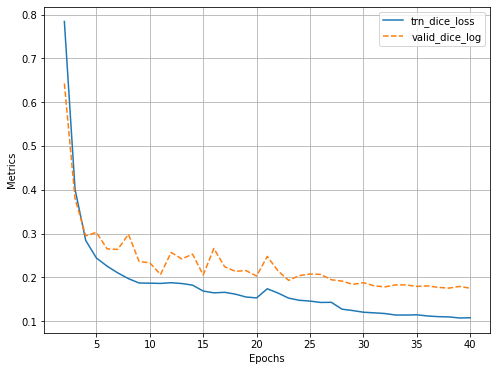

In [44]:
log.plot_epochs(['trn_dice_loss','valid_dice_log'])

100%|██████████| 141/141 [00:00<00:00, 34518.00it/s]


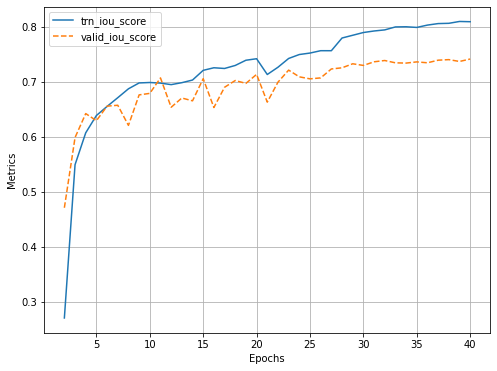

In [45]:
log.plot_epochs(['trn_iou_score','valid_iou_score'])

In [46]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [47]:
img, mask = valid_ds.choose()

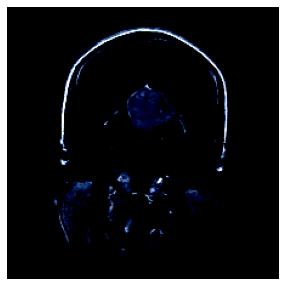

In [48]:
show(img)

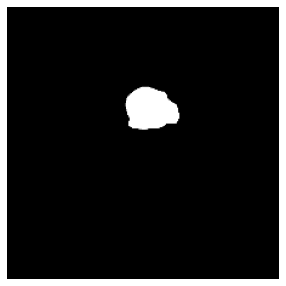

In [49]:
show(mask.reshape((224,224)))

In [50]:
x_tensor = torch.from_numpy(img).to(DEVICE).unsqueeze(0)

In [51]:
pr_mask = best_model.predict(x_tensor)

In [52]:
pr_mask = (pr_mask.squeeze().cpu().numpy().round())

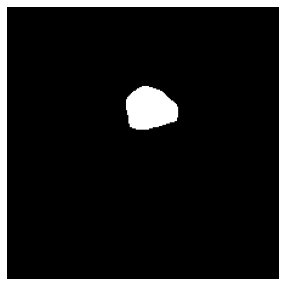

In [53]:
show(pr_mask)

# Inferencing on new image

In [54]:
index = np.random.choice(len(combined))

In [55]:
img_path, mask_path = combined[index]

In [56]:
img_inference = read(img_path,1)
mask = read(mask_path)

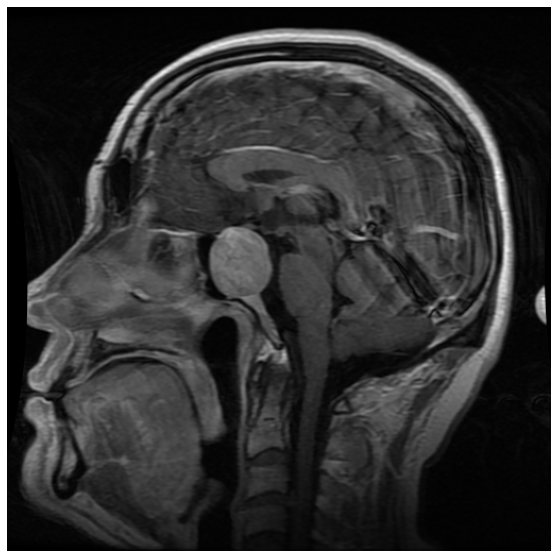

In [57]:
show(img_inference)

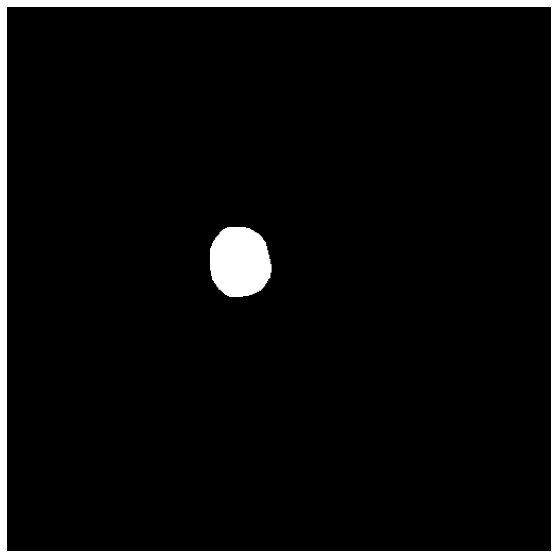

In [58]:
show(mask)

In [59]:
prepro_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [60]:
img_inference = cv2.resize(img_inference, (224,224))

In [61]:
img = img_inference.copy()

In [62]:
img = img/255.

In [63]:
img = np.array(img)

In [64]:
img = prepro_fn(img)

In [65]:
img = to_tensor(img)

In [66]:
x_tensor = torch.from_numpy(img).to(DEVICE).unsqueeze(0)

In [67]:
pr_mask = best_model.predict(x_tensor)

In [68]:
pr_mask = (pr_mask.squeeze().cpu().numpy().round())

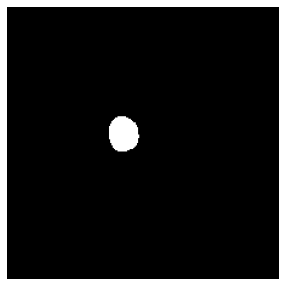

In [69]:
show(pr_mask)

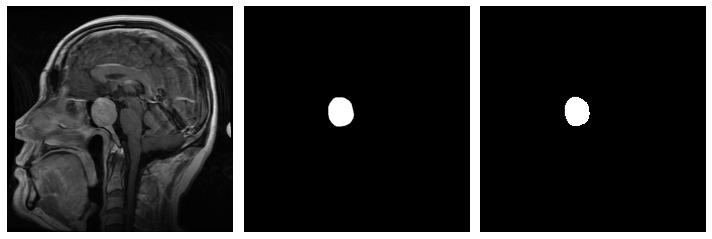

In [70]:
subplots([img_inference, mask, pr_mask],figsize=(10,10))

# Inference on multiple images

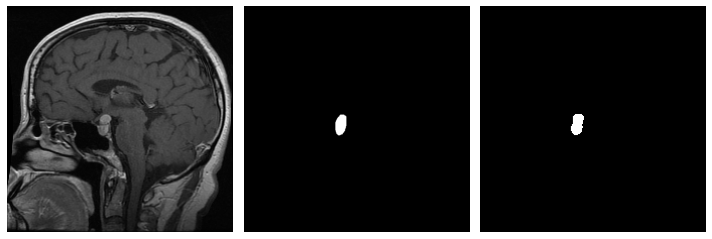

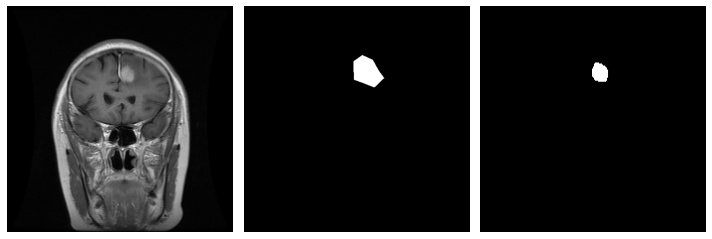

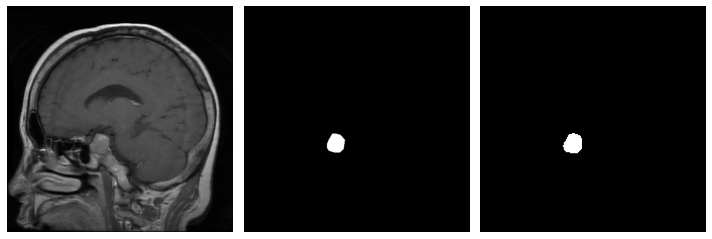

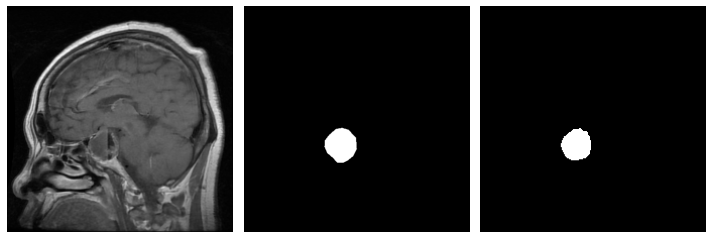

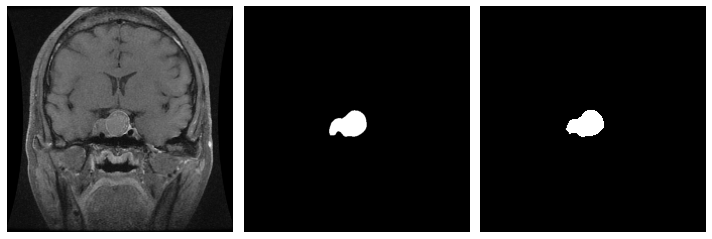

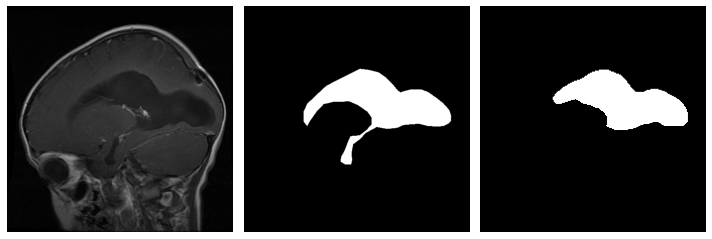

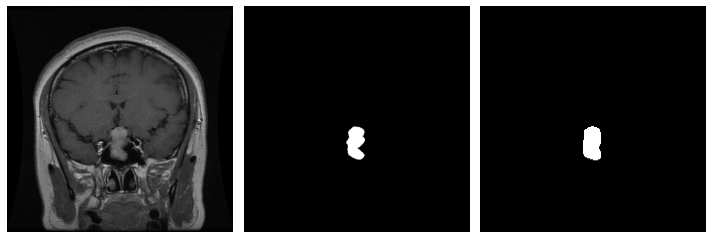

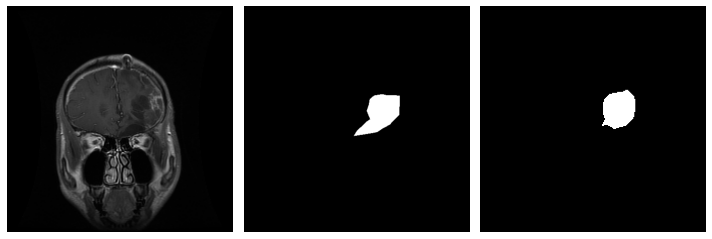

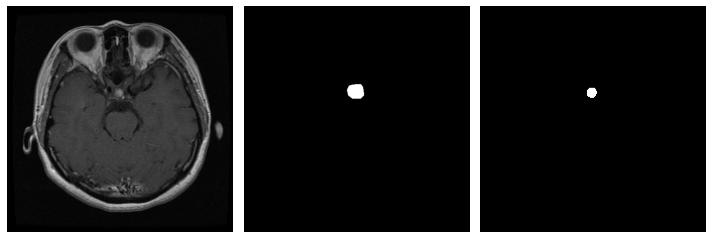

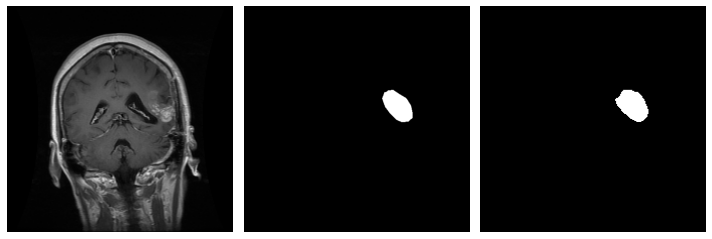

In [73]:
for i in range(10):
  index = np.random.choice(len(combined))
  img_path, mask_path = combined[index]
  img_inference = read(img_path,1)
  mask = read(mask_path)
  prepro_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
  img_inference = cv2.resize(img_inference, (224,224))
  img = img_inference.copy()
  img = img/255.
  img = np.array(img)
  img = prepro_fn(img)
  img = to_tensor(img)
  x_tensor = torch.from_numpy(img).to("cpu").unsqueeze(0) ### cpu inferecning
  pr_mask = best_model.to("cpu").predict(x_tensor)  ## cpu inferencing
  pr_mask = (pr_mask.squeeze().cpu().numpy().round())
  subplots([img_inference, mask, pr_mask],figsize=(10,10))